In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [221]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [222]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [223]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [224]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [225]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier

primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [226]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

ugrhi10 = trainingd

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [227]:
ugrhi10

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [228]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '06 - ALTO TIÊTE']

In [229]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [230]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [231]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())

valor NaN: 2


In [232]:
trainingd = trainingd.dropna(axis=0,how='any')


In [233]:
for field in trainingd.columns:
    print(field, 'NaN:', trainingd[field].isnull().sum())
trainingd

valor NaN: 0


,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [234]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < inferior.valor)]

outlier

primeiro_quartil: valor    6.583333
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.002667
Name: 0.75, dtype: float64
fig: valor    0.419333
dtype: float64
Inferior: valor    5.954333
dtype: float64
Superior: valor    7.631667
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1979-11-30,5.916667
1985-03-31,5.883333


In [235]:
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2019-01-31,7.056429
2019-03-31,7.323333
2019-05-31,7.405000


In [236]:
#Remove a última linha do dataframe
trainingd = trainingd.drop(trainingd[trainingd.index == '2019-09-30'].index)

In [237]:
trainingd.describe()

,valor
count,248.000000
mean,6.793328
std,0.294764
min,5.883333
25%,6.581944
50%,6.838095
75%,7.001821
max,7.405000


In [238]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingds.valor < inferior.valor] = 6.79

ugrhi06 = trainingd

outlier = trainingd[(trainingd.valor < inferior.valor)]

outlier

,valor
data_coleta,


In [239]:
X = ugrhi10
y = ugrhi06

assert X.shape == (len(X),1)
assert y.shape == (len(y),1)

In [240]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (0 a 1).
sc = MinMaxScaler()
X = sc.fit_transform(X)
y = sc.fit_transform(y)

In [241]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

#y_test

In [242]:

model = Sequential()
model.add(Dense(units = 10, activation = 'relu'))
model.add(Dense(units = 21, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

#Treina o modelo
model.fit(X_train,y_train, batch_size = 32, epochs = 100)

y_pred = model.predict(X_test)
#y_pred = y_pred.reshape(-1, 1)
y_pred = sc.inverse_transform(y_pred)

X_test = sc.inverse_transform(X_test)
y_test = sc.inverse_transform(y_test)


Train on 173 samples
Epoch 1/100
173/173 [==============================] - 0s 2ms/sample - loss: 0.7006 - mean_absolute_error: 0.7006
Epoch 2/100
173/173 [==============================] - 0s 103us/sample - loss: 0.6631 - mean_absolute_error: 0.6631
Epoch 3/100
173/173 [==============================] - 0s 78us/sample - loss: 0.6203 - mean_absolute_error: 0.6203
Epoch 4/100
173/173 [==============================] - 0s 154us/sample - loss: 0.5767 - mean_absolute_error: 0.5767
Epoch 5/100
173/173 [==============================] - 0s 73us/sample - loss: 0.5339 - mean_absolute_error: 0.5339
Epoch 6/100
173/173 [==============================] - 0s 178us/sample - loss: 0.4926 - mean_absolute_error: 0.4926
Epoch 7/100
173/173 [==============================] - 0s 77us/sample - loss: 0.4533 - mean_absolute_error: 0.4533
Epoch 8/100
173/173 [==============================] - 0s 165us/sample - loss: 0.4152 - mean_absolute_error: 0.4152
Epoch 9/100
173/173 [==============================] - 0

173/173 [==============================] - 0s 139us/sample - loss: 0.1428 - mean_absolute_error: 0.1428
Epoch 72/100
173/173 [==============================] - 0s 159us/sample - loss: 0.1428 - mean_absolute_error: 0.1428
Epoch 73/100
173/173 [==============================] - 0s 151us/sample - loss: 0.1427 - mean_absolute_error: 0.1427
Epoch 74/100
173/173 [==============================] - 0s 155us/sample - loss: 0.1424 - mean_absolute_error: 0.1424
Epoch 75/100
173/173 [==============================] - 0s 162us/sample - loss: 0.1424 - mean_absolute_error: 0.1424
Epoch 76/100
173/173 [==============================] - 0s 123us/sample - loss: 0.1423 - mean_absolute_error: 0.1423
Epoch 77/100
173/173 [==============================] - 0s 116us/sample - loss: 0.1423 - mean_absolute_error: 0.1423
Epoch 78/100
173/173 [==============================] - 0s 120us/sample - loss: 0.1423 - mean_absolute_error: 0.1423
Epoch 79/100
173/173 [==============================] - 0s 167us/sample - los

In [243]:
y_predt = model.predict(X_train)
#y_pred = y_pred.reshape(-1, 1)
y_predt = sc.inverse_transform(y_predt)

X_train = sc.inverse_transform(X_train)

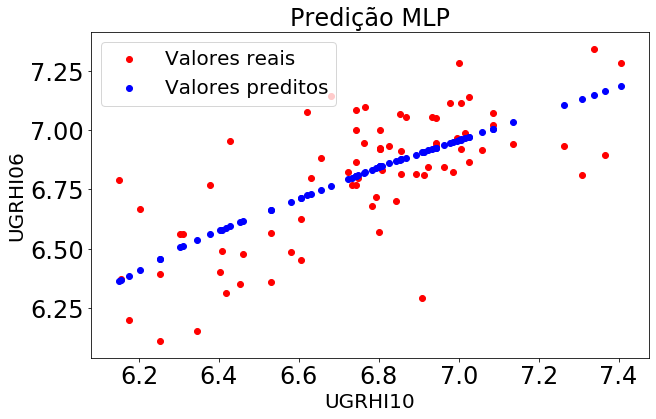

In [244]:

plt.scatter(X_test,y_test,color='red',marker = 'o',label='Valores reais')
plt.scatter(X_test,y_pred,color='blue',label='Valores preditos')
#plt.plot(y_pred,color='blue',label='Dados previsto')
#plt.plot(y_test,color='blue',label='Dados teste')
plt.xlabel('UGRHI10')
plt.ylabel('UGRHI06')
plt.legend()
plt.title('Predição MLP')
plt.show()

In [245]:
def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

def r2(y_pred,y_true):
    rscore = r2_score(y_true,y_pred)
    return rscore

In [247]:
print('\n')
print('MAPE TESTE:',round(mape(y_pred,y_test)[0],2),'%')
print('RMSE TESTE:',round(rmse(y_pred,y_test),2))
print('R TESTE:',round(r2(y_pred,y_test),2))
print('\n')

print('\n')
print('MAPE TREINO:',round(mape(y_predt,X_train)[0],2),'%')
print('RMSE TREINO:',round(rmse(y_predt,X_train),2))
print('R TREINO:',round(r2(y_predt,X_train),2))
print('\n')



MAPE TESTE: 1.72 %
RMSE TESTE: 0.2
R TESTE: 0.49




MAPE TREINO: 2.17 %
RMSE TREINO: 0.1
R TREINO: 0.85




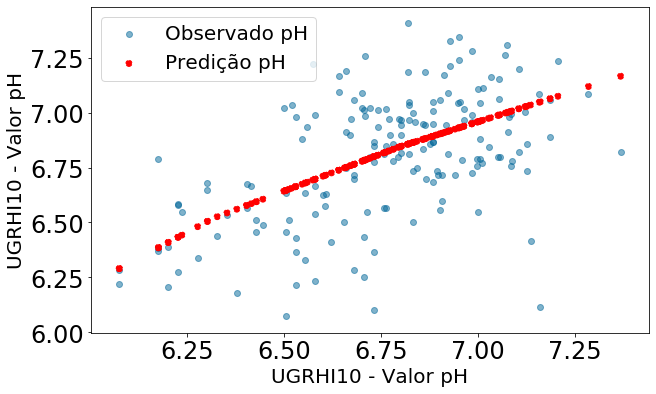

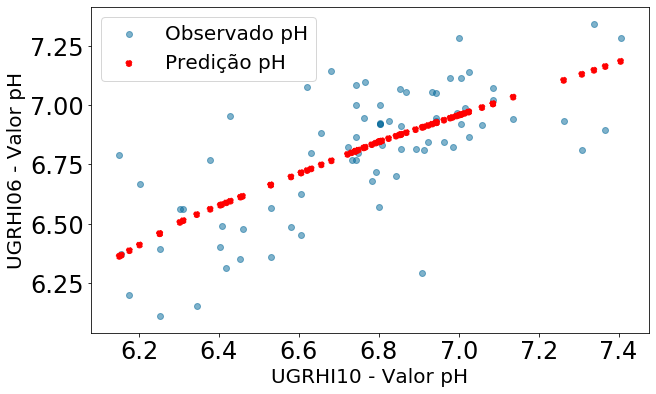

In [248]:
train_y = y_train.reshape(-1, 1)
observado_treino = sc.inverse_transform(train_y)
previsoes_treino = y_predt

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.scatter(X_train, observado_treino, color = '#006699', alpha=0.5, label = 'Observado pH')
plt.scatter(X_train, previsoes_treino, color = 'red',linestyle = '--', label = 'Predição pH')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('UGRHI10 - Valor pH')
plt.ylabel('UGRHI10 - Valor pH')
plt.legend()
#plt.grid()
plt.show()

observado_test = y_test
previsoes = y_pred

#Plotagem do gráfico
#plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.scatter(X_test, observado_test, color = '#006699', alpha=0.5, label = 'Observado pH')
plt.scatter(X_test, previsoes, color = 'red',linestyle = '--', label = 'Predição pH')
#plt.title('Predição do pH com lag = 10%')
plt.xlabel('UGRHI10 - Valor pH')
plt.ylabel('UGRHI06 - Valor pH')
plt.legend()
#plt.grid()
plt.show()

In [249]:
novo = trainingd.reset_index()

X = novo['data_coleta'].values
y = novo['valor'].values

#len(X[174:248])

p = []

for i in range(len(previsoes)):
    p.append(round(previsoes[i][0],2))

   

obj = {'data': X[173:248], 'prev': p}

dfnovo = pd.DataFrame(data=obj)
dfnovo

novo168 = dfnovo

dfnovo.loc[dfnovo.data > '2016-11-01']



,data,prev
58,2016-11-30,6.93
59,2017-01-31,6.66
60,2017-03-31,6.79
61,2017-05-31,6.99
62,2017-07-31,6.97
63,2017-09-30,6.82
64,2017-11-30,7.01
65,2018-01-31,7.16
66,2018-03-31,6.60
67,2018-05-31,6.61


In [250]:
novo168.loc[novo168.data > '2016-11-01']

,data,prev
58,2016-11-30,6.93
59,2017-01-31,6.66
60,2017-03-31,6.79
61,2017-05-31,6.99
62,2017-07-31,6.97
63,2017-09-30,6.82
64,2017-11-30,7.01
65,2018-01-31,7.16
66,2018-03-31,6.60
67,2018-05-31,6.61


In [251]:
a = [6.85] #predito
b = [6.80] #real

a = np.array([6.85])
b = np.array([6.80])

def mapes(y_pred,y_true):
    mape = (abs((y_true - y_pred))/y_true)
    return mape

print('Chuvoso')
print('MAPE TESTE:',round(mapes(6.85,6.80),2),'%')
print('RMSE TESTE:',round(rmse(a,b),2))
print('R TESTE:',round(r2(a,b),2))

a = [6.97]
b = [8.20]

a = np.array([6.97])
b = np.array([8.20])

def mapes(y_pred,y_true):
    mape = (abs((y_true - y_pred))/y_true)
    return mape

print('Seco')
print('MAPE TESTE:',round(mapes(6.97,8.20),2),'%')
print('RMSE TESTE:',round(rmse(a,b),2))
print('R TESTE:',round(r2(a,b),2))

Chuvoso
MAPE TESTE: 0.01 %
RMSE TESTE: 0.05
R TESTE: nan
Seco
MAPE TESTE: 0.15 %
RMSE TESTE: 1.23
R TESTE: nan


/home/anderson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/anderson/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [167]:
trainingd

,valor
data_coleta,
1978-01-31,6.680000
1978-03-31,6.680000
1978-05-31,6.440000
1978-07-31,6.560000
1978-09-30,6.110000
...,...
2018-11-30,7.041538
2019-01-31,7.056429
2019-03-31,7.323333
